In [1]:
from __future__ import division
import scipy.constants as const
import scipy
from scipy.io import wavfile
from IPython.core.display import HTML
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal 
%matplotlib inline

In [2]:
rate = 44100 #44.1 khz
key2freq = lambda n : 2 ** ((n+1-49)/12) * 440 # convert a piano key n to a frequency in Hz
keytofrequency = {}
for i in range(90):
    keytofrequency[i] = key2freq(i)
frequencytokey = {}
for el in keytofrequency:
    frequencytokey[keytofrequency[el]] = el


In [3]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it
def wavPlayer(filepath):
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))
    
def playMusic(title, rate, music):
    # write the file on disk, and show in in a Html 5 audio player
    music_wav = music * 2**13
    wavfile.write(title + '.wav', rate, music_wav.astype(np.int16))
    wavPlayer(title + '.wav')

In [4]:
def song_from_notes(notes):

    note_duration = 0.5 # per key, in sec
    music_duration = note_duration * len(notes)
    time = np.linspace(0, music_duration, num=rate*music_duration) # indices for 0-16 secs spaced apart by 1/44100
    song = np.zeros(len(time))

    sinwave = lambda f,t : np.sin(2*np.pi*f*t) # generate a sinusoid of frequency f Hz over time t

    idx_note = 0
    for note in notes:
        if note: # if note == 0, skip.
            freq = key2freq(note) # frequency of each note
            song[idx_note*rate*note_duration : (idx_note+1)*rate*note_duration-1] = \
                    sinwave(freq,
                            time[idx_note*rate*note_duration : (idx_note+1)*rate*note_duration-1 ] 
                            ) #generates the sinusoids for the song, in .5 sec intervals
        idx_note += 1
        
    return song

In [5]:
def notes_from_wav(wav_file):
        
    notes = []
    rate, track1_data = wavfile.read("/Users/mehabakshi/proj126/markovian-music/fur_elise.wav") #import song
    
    return notes


In [6]:
def stochastic_matrix(notes, degree=1):
    matrix = np.zeros((88,88))
    for i in range(len(notes)):
        curr_note = notes[i]
        if i < len(notes)-1:
            next_note = notes[i+1]
        else:
            next_note = None
        if next_note:
            matrix[curr_note][next_note] += 1
    return normalize(matrix)

def normalize(notes):
    l = len(notes)
    totals = notes.sum(axis=1)
    new_matrix = np.array([])
    for i in range(l):
        if totals[i] == 0:
            new_matrix = np.append(new_matrix, notes[i])
            continue
        new_row = [el/totals[i] for el in np.nditer(notes[i])]
        new_matrix = np.append(new_matrix, new_row)
    return new_matrix.reshape(l,l)
    
notes = [47, 47, 49, 49, 47, 47]
test = stochastic_matrix(notes)


In [7]:
def random_walk(stoch_matrix, size):
    initial_note = 47
    distribution = stoch_matrix[initial_note]
    result = np.array([initial_note])
    for i in range(1, size):
        x = np.sum(distribution)
        if not x:
            next_val = np.random.choice(np.arange(0,88))
            result = np.append(result, next_val)
            distribution = stoch_matrix[next_val]
        else:
            next_val = np.random.choice(np.arange(0,88), 1, p = distribution)
            result = np.append(result, next_val)
            distribution = stoch_matrix[next_val[0]]
    return result


In [9]:
# Get notes from wav
notes = notes_from_wav(wavfile)
notes = [np.random.choice(range(88)) for i in range(100)]
notes = [47, 47, 49, 49, 47, 47, 44, 44, 47, 47, 44, 44, 42, 42, 42, 0, 47, 47, 49, 49, 47, 47, 44, 44, 47, 44, 42, 44, 40, 40, 40, 0]# Calculate stochastic matrix
matrix = stochastic_matrix(notes)

# Create a random walk of notes, starting from a particular note
generated_song_notes = random_walk(matrix, len(notes))

# play song for notes
playMusic("test2", rate, song_from_notes(notes = [47, 47, 49, 49, 47, 47, 44, 44, 47, 47, 44, 44, 42, 42, 42, 0, 47, 47, 49, 49, 47, 47, 44, 44, 47, 44, 42, 44, 40, 40, 40, 0]))
playMusic("test1", rate, song_from_notes(generated_song_notes))

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


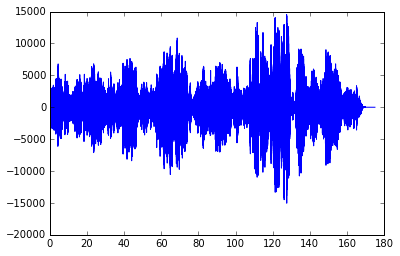

In [42]:
rate, track1_data = wavfile.read("/Users/Ujval/Documents/berkeley/ee126/proj/markovian-music/fur_elise.wav") #import song

flattened = (track1_data[:, 1] + track1_data[:,0])/2
frequencies = abs(np.fft.fft(flattened))

t = np.linspace(0, (len(track1_data)-1)/rate, len(track1_data))
plt.plot(t, flattened)
plt.show()

#playMusic('gymnopedie1_played', rate, data_song1)

129 34436 129
[ 0.          0.00390625  0.0078125   0.01171875  0.015625    0.01953125
  0.0234375   0.02734375  0.03125     0.03515625  0.0390625   0.04296875
  0.046875    0.05078125  0.0546875   0.05859375  0.0625      0.06640625
  0.0703125   0.07421875  0.078125    0.08203125  0.0859375   0.08984375
  0.09375     0.09765625  0.1015625   0.10546875  0.109375    0.11328125
  0.1171875   0.12109375  0.125       0.12890625  0.1328125   0.13671875
  0.140625    0.14453125  0.1484375   0.15234375  0.15625     0.16015625
  0.1640625   0.16796875  0.171875    0.17578125  0.1796875   0.18359375
  0.1875      0.19140625  0.1953125   0.19921875  0.203125    0.20703125
  0.2109375   0.21484375  0.21875     0.22265625  0.2265625   0.23046875
  0.234375    0.23828125  0.2421875   0.24609375  0.25        0.25390625
  0.2578125   0.26171875  0.265625    0.26953125  0.2734375   0.27734375
  0.28125     0.28515625  0.2890625   0.29296875  0.296875    0.30078125
  0.3046875   0.30859375  0.3125     

/Users/Ujval/Documents/berkeley/ee126/venv/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6699: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(array([[  7.40753303e-05,   1.99382141e-02,   1.72865782e-02, ...,
           4.72609305e-02,   1.65481433e-02,   1.06627259e-01],
        [  8.67080510e-05,   2.05627912e-02,   6.63807789e-03, ...,
           3.09761881e-02,   8.74735212e-03,   7.63581065e-02],
        [  7.23443474e-06,   2.54568569e-03,   1.10203332e-03, ...,
           4.12120593e-03,   2.40110487e-02,   3.39493714e-04],
        ..., 
        [  7.23443474e-06,   2.56722924e-03,   8.00163713e-04, ...,
           2.74182972e-02,   2.98639322e-02,   1.10091973e-01],
        [  8.67080510e-05,   2.08649072e-02,   7.16022596e-03, ...,
           3.28873360e-03,   6.38624600e-03,   2.02135529e-02],
        [  7.40753303e-05,   1.95764872e-02,   1.76374322e-02, ...,
           7.01072349e-03,   8.62933771e-03,   2.16457158e-02]]),
 array([ 0.       ,  0.0078125,  0.015625 ,  0.0234375,  0.03125  ,
         0.0390625,  0.046875 ,  0.0546875,  0.0625   ,  0.0703125,
         0.078125 ,  0.0859375,  0.09375  ,  0.1015625, 

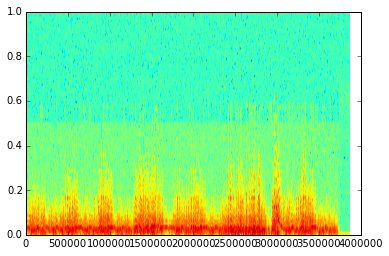

In [65]:

frequencies, times, specto = signal.spectrogram(flattened)
print len(frequencies), len(times), len(specto)
print frequencies
print times
print len(flattened)
print "---"

from pylab import specgram

specgram(flattened)
